# Testing for Peak Integration in Python using Derivative Spectra



## Preliminary on Spectral Line Shapes


### Lorentzian

Given by $L = \frac{1}{1+x^2}$

Variable $x$ is defined by $x = \frac{p-p_0}{\omega /2}$

+ $p_0$ Position of the Maximum
+ $p$ ... Position
+ $\omega$ ... Full WIdth at Half Maximum

### Gaussian 

$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x- \mu)^2}{2\sigma^2}}$

With $\mu$ expectation value and $\sigma^2$ variance.


Some useful symmetries and derivatives:

+ Unimodal: first derivative is positive for $x < \mu$ and negative for $ x > \mu$
+ First Derivative $f'(x) = - \frac{x-\mu}{\sigma^2}f(x)$
+ Second Derivative $f''(x) = \frac{(x-\mu)^2 - \sigma^2}{\sigma^4}f(x)$


### Voigt

Convolution of Gaussian and Lorentzian Function given by:

$V(x,\sigma,\gamma)= \int_{-\infty}^{\infty}G(x';\sigma)L(x-x';\gamma)dx'$





In [153]:
# Modules Import

import numpy as np
from scipy import signal
from scipy.ndimage import shift
import matplotlib.pyplot as plt

Note for a Gaussian Peak we have the Integral:

$\int_{-\infty}^{\infty} a e^{-(x-b)²/2c^2}dx = ac*\sqrt{2\pi}$

So in this test phase we can directly influence our intensity by multiplying with an arbitrary Parameter $a$

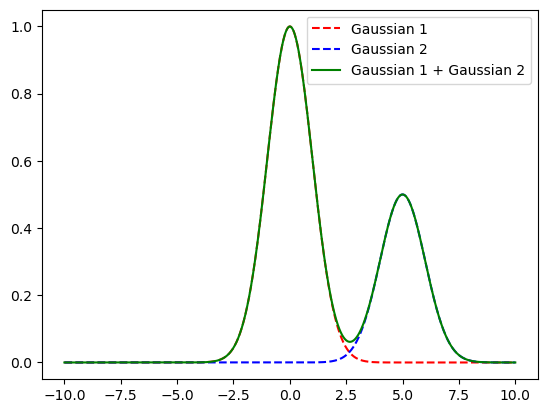

In [154]:
def gaussian(x,mean,std_dev,intensity):
    return intensity*np.exp(-(x--mean)**2/(2*std_dev**2))


x = np.linspace(-10,10,1000)

mean,std_dev,intensity = 0,1,1
mean2,std_dev2,intensity2 = 0,1,0.5

shift_horizontal = 5

y1 = gaussian(x,mean,std_dev,intensity)
y2 = gaussian(x-shift_horizontal,mean2,std_dev2,intensity2)

y_total = y1 + y2

plt.plot(x,y1,label='Gaussian 1', color = "red", linestyle = "--")
plt.plot(x,y2,label='Gaussian 2', color = "blue", linestyle = "--")
plt.plot(x,y_total ,label='Gaussian 1 + Gaussian 2', color = "green")
plt.legend()
plt.show()

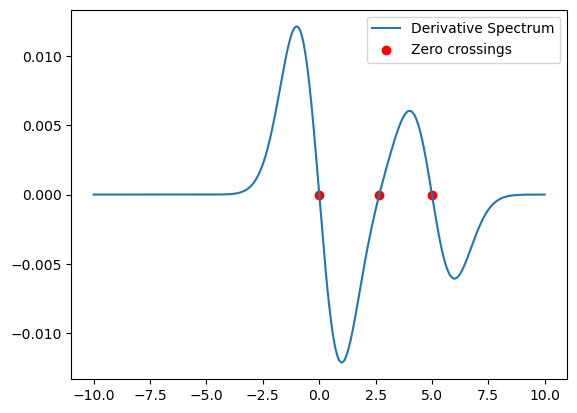

In [155]:
# Calculate the Derivative Spetrum

y_prime = np.gradient(y_total)

def derivative_spectrum(y_data):
    """ 
    Calculates the Numerical Derivative using the gradient
    """
    return np.gradient(y_data)

def find_zero_crossing_lin_int(x_data, y_prime, tol = 1e-5):
    """ 
    Finds zero crossing in the given derivative spectrum

    For this we use a linear interpolation approach (i.e sign change yi yi-1 <0)
    """

    zero_crossings = []
    zero_crossings_indices = []
    for i in range(1,len(y_prime)):
        if y_prime[i-1] * y_prime[i] < 0:
            zero_crossing = x_data[i-1] - y_prime[i-1] * (x_data[i] - x_data[i-1])/ (y_prime[i] - y_prime[i-1])
            zero_crossings.append(zero_crossing)
            zero_crossings_indices.append(i)
    return zero_crossings, zero_crossings_indices

zero_crossings, zero_crossings_indices = find_zero_crossing_lin_int(x,y_prime)


plt.plot(x,y_prime, label="Derivative Spectrum")
plt.scatter(zero_crossings, np.zeros_like(zero_crossings), color = "red", label="Zero crossings")
plt.legend()
plt.show()




# Some Integration Tests

We can compute the left and right area using the zero crossing of the peak. We dann use a optimizer function to find the correct shift between the two areas

0.0038224489964678865
0.003749827006871792
-0.0008360257625040293
-0.0011272058580505395
-0.0010920930587249161
-0.0011258934291111002
-0.0011427835494887337
-0.0011391798587711208
-0.0011431258264777283
-0.0011445944951568691
-0.0011444595497465508
-0.0011448589183248592
-0.0011448416572846648
-0.0011449353853495783
-0.0011449528818750776
-0.0011449737270243024
-0.0011449846979234395
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995
-0.0011449937738207995


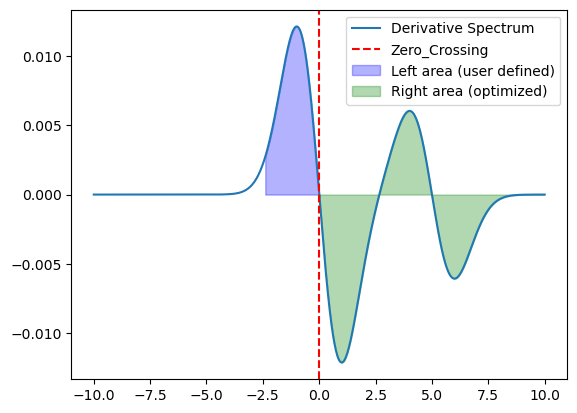

In [156]:
# First of find the x data that is most close to the zero crossing
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
def balance_area_spectrum(x,y_prime,left_boundary_index,zero_crossing, right_boundary_index=None):
    """
    A function to balance the areas in the derivative spectrum around the zero crossing 
    """

    if left_boundary_index >=zero_crossing:
        raise ValueError("Left Boundary must be before the zero crossing")
    

    x_left = x[left_boundary_index:zero_crossing+1]
    y_left = y_prime[left_boundary_index:zero_crossing +1]

    left_area = np.trapz(y_left,x_left)

    def balance_areas(shift_idx):

        shifted_right_idx = zero_crossing + int(shift_idx)
        if shifted_right_idx >= len(x):
            return np.inf # Prevent out of bounds
        
        x_shifted_right = x[zero_crossing:shifted_right_idx + 1]
        y_shifted_right = y_prime[zero_crossing:shifted_right_idx + 1]


        
        right_area = np.trapz(y_shifted_right,x_shifted_right)
        
        # End the closure to give back the diverence in areas
        print(np.abs(left_area) - np.abs(right_area))
        return np.abs(left_area) - np.abs(right_area)
    
    result = minimize_scalar(balance_areas, bounds = (0, len(x)- zero_crossing), method="bounded")

    optimal_shift = int(result.x)

    x_balanced_right = x[zero_crossing:zero_crossing + optimal_shift +1]
    y_balanced_right = y_prime[zero_crossing:zero_crossing + optimal_shift + 1]

    balanced_right_area = np.trapz(y_balanced_right,x_balanced_right)

    plt.plot(x,y_prime, label="Derivative Spectrum")
    plt.axvline(x=x[zero_crossing], color = "r", linestyle="--",label="Zero_Crossing")
    plt.fill_between(x_left,y_left,color="blue", alpha=0.3, label="Left area (user defined)")
    plt.fill_between(x_balanced_right,y_balanced_right,color="green",alpha=0.3, label="Right area (optimized)")
    plt.legend()
    plt.show()


    
balance_area_spectrum(x,y_prime, 380, zero_crossings_indices[0])

0.0015635300426571144
0.0015635300426571144
0.0015635259855179308
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56353D-03    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.564D-03
  F =   1.5635259855179308E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


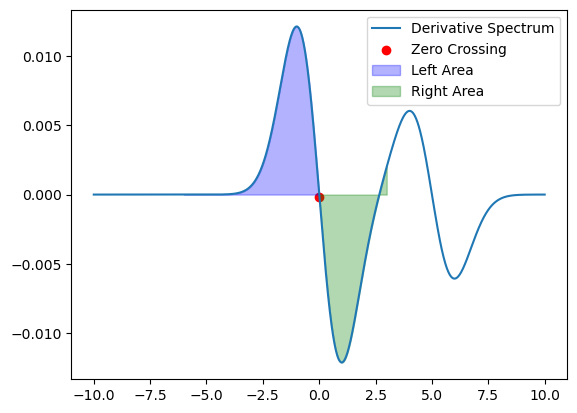

In [212]:
# ok new try use minimizer algorithm

from scipy.optimize import minimize



def area_difference(right_bound, x,y_prime, left_bound, zero_crossing):
    right_bound = int(right_bound[0])

    left_area = np.trapz(y_prime[left_bound:zero_crossing], x[left_bound:zero_crossing])
    right_area = np.trapz(y_prime[zero_crossing:right_bound], x[zero_crossing:right_bound])

    print(np.abs(left_are)-  np.abs(right_area))
    return np.abs(left_area) - np.abs(right_area)

left_bound = 200
zero_crossing = zero_crossings_indices[0]
initial_right_bound = 650

def callbackF(xk):
    print("Current Right bound: ", xk)

result = minimize(area_difference,x0=[initial_right_bound], args=(x,y_prime,left_bound, zero_crossing), 
                  bounds=[(zero_crossing,len(x)-1)],method="L-BFGS-B",options={"eps":1e-2,"disp":True},callback=callbackF)

print(result.fun)

# Ergebnis der Minimierung
right_bound = int(result.x[0])

# Plotten des Ableitungsspektrums und Markieren der Nullstellen
plt.plot(x, y_prime, label="Derivative Spectrum")
plt.scatter(x[zero_crossing], y_prime[zero_crossing], color="red", label="Zero Crossing")

# Markieren der Bereiche mit fill_between
plt.fill_between(x[left_bound:zero_crossing], y_prime[left_bound:zero_crossing], color='blue', alpha=0.3, label='Left Area')
plt.fill_between(x[zero_crossing:right_bound], y_prime[zero_crossing:right_bound], color='green', alpha=0.3, label='Right Area')

plt.legend()
plt.show()





634


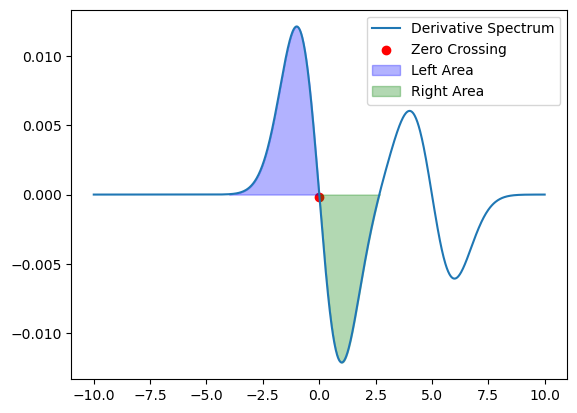

In [229]:
# Lets try a manual optimization


def area_difference(right_bound, x,y_prime, left_bound, zero_crossing):
    right_bound = int(right_bound)

    left_area = np.trapz(y_prime[left_bound:zero_crossing], x[left_bound:zero_crossing])
    right_area = np.trapz(y_prime[zero_crossing:right_bound], x[zero_crossing:right_bound])

    return np.abs(left_area) - np.abs(right_area)


left_bound = 300
zero_crossing = zero_crossings_indices[0]
initial_right_bound = 550
user_top_bound = 700

best_right_bound = initial_right_bound
best_area_diff = area_difference(initial_right_bound,x,y_prime,left_bound,zero_crossing)

step_size=1


for right_bound in range(initial_right_bound, user_top_bound, step_size):
    current_area_diff = area_difference(right_bound,x,y_prime, left_bound, zero_crossing)
    if current_area_diff < best_area_diff:
        best_area_diff = current_area_diff
        best_right_bound = right_bound

right_bound = best_right_bound

print(right_bound)

# Plotten des Ableitungsspektrums und Markieren der Nullstellen
plt.plot(x, y_prime, label="Derivative Spectrum")
plt.scatter(x[zero_crossing], y_prime[zero_crossing], color="red", label="Zero Crossing")

# Markieren der Bereiche mit fill_between
plt.fill_between(x[left_bound:zero_crossing], y_prime[left_bound:zero_crossing], color='blue', alpha=0.3, label='Left Area')
plt.fill_between(x[zero_crossing:right_bound], y_prime[zero_crossing:right_bound], color='green', alpha=0.3, label='Right Area')

plt.legend()
plt.show()